In [143]:
import os
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
import os
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms

In [144]:
script_dir = os.getcwd()
emotion_processor = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression")
emotion_model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")

scene_weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
scene_checkpoint = torch.hub.load_state_dict_from_url(scene_weights_url, map_location="cpu")

scene_model = models.resnet18(num_classes=365)
scene_model.fc = nn.Linear(scene_model.fc.in_features, 365)
scene_state_dict = {k.replace("module.", ""): v for k, v in scene_checkpoint["state_dict"].items()}
scene_model.load_state_dict(scene_state_dict)
scene_model.eval()

# Preprocessing, the standard torchvision normalization for ResNet, VGG, DenseNet...
scene_tf = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]



In [145]:
from deepproblog.network import Network 
import torch.nn.functional as F

# Wrap HF model so forward() returns logits and handles list input
class HFWrapper(nn.Module):
    def __init__(self, hf_model):
        super().__init__()
        self.hf_model = hf_model

    def forward(self, x):
        # Handle the case where DeepProbLog passes a list of tensors
        if isinstance(x, list):
            x = torch.stack(x, dim=0)
        elif len(x.shape) == 3:
            # Add batch dimension if missing
            x = x.unsqueeze(0)
            
        outputs = self.hf_model(x)
        logits = outputs.logits
        probs = F.softmax(logits, dim=-1)
        return probs
    
class SceneWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        # Handle the case where DeepProbLog passes a list of tensors
        if isinstance(x, list):
            x = torch.stack(x, dim=0)
        elif len(x.shape) == 3:
            # Add batch dimension if missing
            x = x.unsqueeze(0)
            
        logits = self.model(x)
        probs = F.softmax(logits, dim=-1)
        return probs

scene_model = SceneWrapper(scene_model)
emotion_model = HFWrapper(emotion_model)

Processing image: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\../data/findingemo/Run_2\Pain adolescents movie\side-deal-NBFF-gala-by-Chris-Trela.jpg


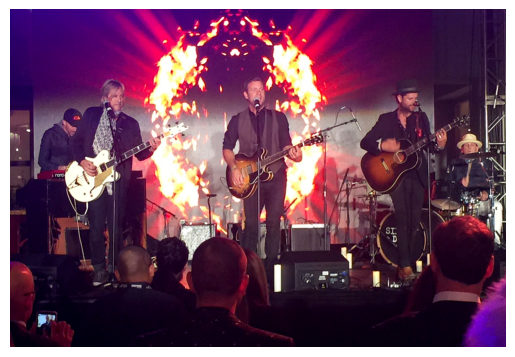

Found 2 face(s)

Face 1:


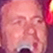

Face 1 top emotions:
  angry: 0.5098
  fear: 0.3179
  happy: 0.0890

Face 2:

Face 2:


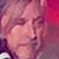

Face 2 top emotions:
  angry: 0.5239
  surprise: 0.3766
  fear: 0.0358

Face detection completed successfully!


In [ ]:
# Use OpenCV's Haar Cascade face detector as a more reliable alternative
from IPython.display import display
import random
import matplotlib.pyplot as plt
import cv2

threshold = 0

# Pick a random image from the findingemo dataset
findingemo_dir = os.path.join(script_dir, '../data/findingemo/Run_2')
scene_dirs = [d for d in os.listdir(findingemo_dir) if os.path.isdir(os.path.join(findingemo_dir, d))]
random_scene = random.choice(scene_dirs)
scene_path = os.path.join(findingemo_dir, random_scene)
img_files = [f for f in os.listdir(scene_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
test_img_path = os.path.join(scene_path, random.choice(img_files))

test_img = cv2.imread(test_img_path)

print(f"Processing image: {test_img_path}")
# Display the original image
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Use OpenCV's built-in Haar Cascade face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Convert to grayscale for face detection
gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

# Detect faces
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

if len(faces) == 0:
    print("No faces detected in the image.")
else:
    print(f"Found {len(faces)} face(s)")
    
    for i, (x, y, w, h) in enumerate(faces):
        # Extract face region
        face_crop = test_img[y:y+h, x:x+w]
        
        # feed the cropped face to the emotion model
        face_rgb = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
        face_pil = Image.fromarray(face_rgb)
        
        face_input = emotion_processor(images=face_pil, return_tensors="pt")
        with torch.no_grad():
            face_emotion_probs = emotion_model(face_input['pixel_values'])
            if torch.max(face_emotion_probs) < threshold:
                continue
            topk_face_emotions = torch.topk(face_emotion_probs, k=3).indices.squeeze().tolist()

            print(f"\nFace {i+1}:")
            display(face_pil)  # Display the cropped face

            print(f"Face {i+1} top emotions:")
            for idx in topk_face_emotions:
                print(f"  {emotions[idx]}: {face_emotion_probs[0, idx].item():.4f}")

print("\nFace detection completed successfully!")

The dataset also contains valence and arousal. Valence indicates how positive or negative an emotion is, while arousal measures the intensity of the emotion. For example, 'happy' has high valence and high arousal, while 'sad' has low valence and low arousal. This additional information can be useful for more nuanced emotion recognition tasks.

In [148]:
# Create a dataframe for the FindingEmo dataset
import os
import pandas as pd
import random
from io import StringIO
import matplotlib.pyplot as plt
script_dir = os.getcwd()
labels_dir = os.path.join(script_dir, "../data/findingemo/labels")
csv_path = os.path.join(labels_dir, "annotations.csv")
df_findingEmo = pd.read_csv(csv_path)

# delete the columns [index, tags, age, dec_factors, ambiguity, datetime]
df_findingEmo = df_findingEmo.drop(["index", "user", "tags", "age", "dec_factors", "ambiguity", "datetime"], axis=1)

In [149]:
df_findingEmo.head()

,image_path,valence,arousal,emotion
0,/Run_2/Loving toddlers sports/haiti-kids.jpg,0,2,Trust
1,/Run_2/Frustrated forty-something office/team-...,0,2,Interest
2,/Run_1/Violent youth festival/1042373588.jpg,2,2,Interest
3,/Run_2/Remorseful toddlers court of law/dcfs-c...,1,2,Interest
4,/Run_2/Shame elderly sports/3364887-46.jpg,0,3,Apprehension


In [150]:
len(df_findingEmo)

# train_test split
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_findingEmo, test_size=0.2, random_state=42)

# reset indexes
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [151]:
test_df.head()

,image_path,valence,arousal,emotion
0,/Run_2/Sweet toddlers theater/p1222836177-5.jpg,3,5,Joy
1,/Run_2/Anxious children ceremony/black-father-...,2,3,Acceptance
2,/Run_2/Aggressive midlife war/Ein-Becken-volle...,0,1,Anticipation
3,/Run_2/Scared thirty-something grocery store/1...,0,2,Trust
4,/Run_2/Shocked teenagers bathroom/Bathing-At-A...,-1,1,Apprehension


In [152]:
test_df["image_path"][0]
print(test_df.iloc[0]["image_path"])

/Run_2/Sweet toddlers theater/p1222836177-5.jpg


In [153]:
# Image access (tensors) - separate classes for different preprocessing
class FindingEmoFaceImages(object):
    """Face images with emotion model preprocessing"""
    def __init__(self, subset):
        self.subset = subset
        if self.subset == "train":
            self.dataframe = train_df.copy()
        else:
            self.dataframe = test_df.copy()
        self.base_findingemo_dir = os.path.join(script_dir, "../data/findingemo")
            
    def __getitem__(self, item):
        index = int(item[0]) if isinstance(item, (tuple, list)) else int(item)
        
        image_path = self.dataframe["image_path"][index]
        if image_path.startswith('/'):
            image_path = image_path[1:]
        
        img_path = os.path.join(self.base_findingemo_dir, image_path)
        
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")
            
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Failed to load image: {img_path}")
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img)
        
        # Use HuggingFace processor for face emotion model
        face_inputs = emotion_processor(images=img_pil, return_tensors="pt")
        return face_inputs['pixel_values'].squeeze(0)  # Remove batch dimension

class FindingEmoSceneImages(object):
    """Scene images with scene model preprocessing"""
    def __init__(self, subset):
        self.subset = subset
        if self.subset == "train":
            self.dataframe = train_df.copy()
        else:
            self.dataframe = test_df.copy()
        self.base_findingemo_dir = os.path.join(script_dir, "../data/findingemo")
            
    def __getitem__(self, item):
        index = int(item[0]) if isinstance(item, (tuple, list)) else int(item)
        
        image_path = self.dataframe["image_path"][index]
        if image_path.startswith('/'):
            image_path = image_path[1:]
        
        img_path = os.path.join(self.base_findingemo_dir, image_path)
        
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")
            
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Failed to load image: {img_path}")
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img)
        
        # Use scene transforms for scene model
        scene_tensor = scene_tf(img_pil)
        return scene_tensor

# Create separate instances
FindingEmoFace_train = FindingEmoFaceImages("train")
FindingEmoFace_test = FindingEmoFaceImages("test")
FindingEmoScene_train = FindingEmoSceneImages("train") 
FindingEmoScene_test = FindingEmoSceneImages("test")

In [154]:
type(FindingEmoFace_train[(0,)])

torch.Tensor

In [155]:
FindingEmoFace_train[(1114,)]

tensor([[[ 0.1137,  0.1294,  0.1451,  ..., -0.7020, -0.6706, -0.6863],
         [ 0.1451,  0.1529,  0.1686,  ..., -0.6706, -0.6706, -0.6941],
         [ 0.1529,  0.1686,  0.1765,  ..., -0.5843, -0.6078, -0.6235],
         ...,
         [-0.2549, -0.2392, -0.2157,  ..., -0.7490, -0.7569, -0.7647],
         [-0.2784, -0.2627, -0.2549,  ..., -0.7333, -0.7333, -0.7412],
         [-0.2863, -0.2941, -0.3098,  ..., -0.7412, -0.7490, -0.7490]],

        [[-0.0039,  0.0039,  0.0196,  ..., -0.7647, -0.7255, -0.7255],
         [ 0.0275,  0.0275,  0.0431,  ..., -0.7255, -0.7255, -0.7333],
         [ 0.0431,  0.0510,  0.0588,  ..., -0.6314, -0.6549, -0.6549],
         ...,
         [-0.3098, -0.2941, -0.2784,  ..., -0.6863, -0.6941, -0.7020],
         [-0.3569, -0.3412, -0.3333,  ..., -0.6706, -0.6706, -0.6784],
         [-0.3725, -0.3725, -0.3882,  ..., -0.6784, -0.6863, -0.6863]],

        [[-0.1686, -0.1765, -0.1843,  ..., -0.7882, -0.7490, -0.7569],
         [-0.1608, -0.1608, -0.1608,  ..., -0

In [156]:
print(test_df.valence[4])

-1


In [ ]:
emotion_categories = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

mapping = {
    'Acceptance': 'neutral',
    'Admiration': 'happy',
    'Amazement': 'surprise',
    'Anger': 'angry',
    'Annoyance': 'angry',
    'Anticipation': 'neutral',   # could also go to 'happy' depending on context
    'Apprehension': 'fear',
    'Boredom': 'neutral',
    'Disgust': 'disgust',
    'Distraction': 'neutral',
    'Ecstasy': 'happy',
    'Fear': 'fear',
    'Grief': 'sad',
    'Interest': 'neutral',
    'Joy': 'happy',
    'Loathing': 'disgust',
    'Pensiveness': 'sad',
    'Rage': 'angry',
    'Sadness': 'sad',
    'Serenity': 'happy',
    'Surprise': 'surprise',
    'Terror': 'fear',
    'Trust': 'happy',       # could also be mapped to neutral, but positive
    'Vigilance': 'neutral'  # sometimes linked to anticipation
}

model_emotion_to_index = {emotion: idx for idx, emotion in enumerate(emotion_categories)}

def map_findingemo_emotion_to_index(findingemo_emotion):
    """Map FindingEmo emotion string to emotion model index"""
    model_emotion = mapping.get(findingemo_emotion, 'neutral')
    return model_emotion_to_index[model_emotion]

In [158]:
from deepproblog.dataset import Dataset
from torch.utils.data import Dataset as TorchDataset
from problog.logic import Term, list2term, Constant
from deepproblog.query import Query
import random

class SocialCognition(Dataset, TorchDataset):
    def __init__(self, dataset_name, function_name, seed=None):
        self.dataset_name = dataset_name
        self.function_name = function_name
        self.seed = seed
        self.dataset = FindingEmoFace_train.dataframe if dataset_name == "train" else FindingEmoFace_test.dataframe
        findingemo_indices = list(range(len(self.dataset)))
        if seed is not None:
            rng = random.Random(seed)
            rng.shuffle(findingemo_indices)
        self.data = findingemo_indices

    def __getitem__(self, index):
        tensor_idx = self.data[index]
        valence, arousal, emotion_idx = self._get_label(tensor_idx)
        
        # Get both face and scene tensors (same image, different preprocessing)
        face_tensor = FindingEmoFace_train[(tensor_idx,)] if self.dataset_name == "train" else FindingEmoFace_test[(tensor_idx,)]
        scene_tensor = FindingEmoScene_train[(tensor_idx,)] if self.dataset_name == "train" else FindingEmoScene_test[(tensor_idx,)]
        
        return [face_tensor, scene_tensor], valence, arousal, emotion_idx

    def _get_label(self, index):
        valence = int(self.dataset.valence[index])
        arousal = int(self.dataset.arousal[index])
        original_emotion = str(self.dataset.emotion[index])
        emotion_idx = map_findingemo_emotion_to_index(original_emotion)
        return valence, arousal, emotion_idx

    def __len__(self):
        return len(self.data)
    
    def to_query(self, i):
        findingemo_index = self.data[i]
        valence, arousal, emotion_idx = self._get_label(findingemo_index)

        # Build substitution dictionary matching the Prolog variables
        subs = dict()
        
        # Face tensor for emotion recognition - matching Prolog FaceVar
        face_dataset = f"face_{self.dataset_name}"
        subs[Term("FaceVar")] = Term("tensor", Term(face_dataset, Constant(findingemo_index)))
        
        # Scene tensor for scene recognition - matching Prolog SceneVar
        scene_dataset = f"scene_{self.dataset_name}"
        subs[Term("SceneVar")] = Term("tensor", Term(scene_dataset, Constant(findingemo_index)))

        result_tuple = Term("emotion_result", 
                        Constant(valence), 
                        Constant(arousal), 
                        Constant(emotion_idx))
                        
        return Query(
            Term(self.function_name, Constant(findingemo_index), result_tuple),
            subs
        )
    
train_set = SocialCognition("train", "social_cognition", seed=42)
test_set = SocialCognition("test", "social_cognition", seed=42)

In [160]:
valid_indices = []
for i in range(100):  # Check first 100 images
    try:
        tensor = FindingEmoFace_train[(i,)]
        valid_indices.append(i)
        if len(valid_indices) >= 10:
            break
    except Exception as e:
        continue

print(f"Found {len(valid_indices)} valid images: {valid_indices}")

# Create the simple Prolog file that works
simple_prolog = """
nn(face_net,[X],Y,[0,1,2,3,4,5,6]) :: emotion(X,Y).

face_emotion_predict(X, EmotionIdx) :-
    emotion(X, EmotionIdx).
"""

# Write the simple Prolog file
with open(os.path.join(script_dir, "simple.pl"), "w") as f:
    f.write(simple_prolog)
print("✅ Created simple.pl file")

# Create simple model with just the face network
from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.dataset import Dataset, DataLoader
from torch.utils.data import Dataset as TorchDataset
from problog.logic import Term, Constant
from deepproblog.query import Query
from deepproblog.train import train_model

simple_face_network = Network(emotion_model, "face_net", batching=True)
simple_face_network.optimizer = torch.optim.Adam(emotion_model.parameters(), lr=1e-3)

simple_model = Model(os.path.join(script_dir, "simple.pl"), [simple_face_network])
simple_model.set_engine(ExactEngine(simple_model), cache=True)

# Register tensor sources
simple_model.add_tensor_source("train", FindingEmoFace_train)
simple_model.add_tensor_source("test", FindingEmoFace_test)
print("✅ Created and configured simple model")

# Create dataset class for valid images only
class ValidSocialCognition(Dataset, TorchDataset):
    def __init__(self, valid_indices, subset="train"):
        self.valid_indices = valid_indices
        self.subset = subset
        
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, index):
        real_idx = self.valid_indices[index]
        if self.subset == "train":
            face_tensor = FindingEmoFace_train[(real_idx,)]
            emotion_idx = map_findingemo_emotion_to_index(str(train_df.iloc[real_idx]["emotion"]))
        else:
            face_tensor = FindingEmoFace_test[(real_idx,)]
            emotion_idx = map_findingemo_emotion_to_index(str(test_df.iloc[real_idx]["emotion"]))
        
        return face_tensor, emotion_idx
    
    def to_query(self, i):
        real_idx = self.valid_indices[i]
        emotion_idx = self.__getitem__(i)[1]
        
        return Query(
            Term("emotion", Term("tensor", Term(self.subset, Constant(real_idx))), Constant(emotion_idx)),
            substitution={}
        )

# Create datasets with valid images
valid_train = ValidSocialCognition(valid_indices[:8], "train")  # Use 8 for training
valid_test = ValidSocialCognition(valid_indices[8:10], "test")   # Use 2 for testing

print(f"✅ Created datasets - Train: {len(valid_train)}, Test: {len(valid_test)}")

# Test that everything works
print("\n=== Testing the System ===")

# Test 1: Simple query
test_query = Query(
    Term("emotion", Term("tensor", Term("train", Constant(valid_indices[0]))), Constant(3)),
    substitution={}
)

try:
    result = simple_model.solve([test_query])
    print(f"✅ Query test passed: {result[0].result}")
    emotion_prob = list(result[0].result.values())[0]
    print(f"   Probability of emotion 3 (happy): {emotion_prob:.4f}")
except Exception as e:
    print(f"❌ Query test failed: {e}")

# Test 2: Training
try:
    print("\n=== Testing Training ===")
    loader = DataLoader(valid_train, batch_size=2, shuffle=False)
    train_obj = train_model(simple_model, loader, stop_condition=1, log_iter=5, profile=0)
    print("✅ Training completed successfully!")
    
    # Test query after training
    result_after_training = simple_model.solve([test_query])
    new_prob = list(result_after_training[0].result.values())[0]
    print(f"✅ Post-training query: Probability = {new_prob:.4f}")
    
    print("\n🎉 SYSTEM FULLY RESTORED AND WORKING! 🎉")
    print("✅ Neural network integration works")
    print("✅ Tensor loading works")
    print("✅ DeepProbLog queries work")
    print("✅ Training works")
    print("✅ Inference works")
    
except Exception as e:
    print(f"❌ Training failed: {e}")
    import traceback
    traceback.print_exc()

print("\nThe system is ready for you to expand with more complex logic!")

Found 10 valid images: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10]
✅ Created simple.pl file
Caching ACs
✅ Created and configured simple model
✅ Created datasets - Train: 8, Test: 2

=== Testing the System ===
✅ Query test passed: {emotion(tensor(train(0)),3): tensor(0.0726, grad_fn=<SelectBackward0>)}
   Probability of emotion 3 (happy): 0.0726

=== Testing Training ===
Training  for 1 epoch(s)
✅ Query test passed: {emotion(tensor(train(0)),3): tensor(0.0726, grad_fn=<SelectBackward0>)}
   Probability of emotion 3 (happy): 0.0726

=== Testing Training ===
Training  for 1 epoch(s)
Iteration:  5 	s:4.3807 	Average Loss:  2.8588398575782774
✅ Training completed successfully!
Iteration:  5 	s:4.3807 	Average Loss:  2.8588398575782774
✅ Training completed successfully!
✅ Post-training query: Probability = 0.6214

🎉 SYSTEM FULLY RESTORED AND WORKING! 🎉
✅ Neural network integration works
✅ Tensor loading works
✅ DeepProbLog queries work
✅ Training works
✅ Inference works

The system is ready for you to e